<a href="https://colab.research.google.com/github/grazder/dul_2021/blob/hw7/Homework7_gans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 260, done.
remote: Counting objects: 100% (89/89), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 260 (delta 57), reused 51 (delta 51), pack-reused 171
Receiving objects: 100% (260/260), 53.34 MiB | 23.44 MiB/s, done.
Resolving deltas: 100% (118/118), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=22409 sha256=86e7c32b78529feab3fd276856e4b29a7a287c10c8f8cbdb8ffe6299b48bc4c3
  Stored in directory: /tmp/pip-ephem-wheel-cache-vsixf32r/wheels/55/59/29/0fb1c635652157734

In [17]:
from dul_2021.utils.hw7_utils import *

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Question 1: GANs on CIFAR-10

In this exercise, you will train GANs on CIFAR-10. Execute the cell below to visualize the dataset. 

Files already downloaded and verified


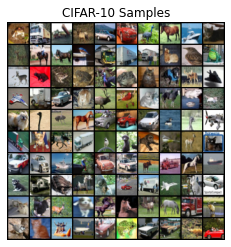

In [19]:
visualize_q1_data()

 We'll use the CIFAR-10 architecture from the [SN-GAN paper](https://arxiv.org/pdf/1802.05957.pdf), with $z \in \mathbb R ^{128}$, with $z \sim \mathcal N (0, I_{128})$. Instead of upsampling via transposed convolutions and downsampling via pooling or striding, we'll use these DepthToSpace and SpaceToDepth methods for changing the spatial configuration of our hidden states. 

```
class DepthToSpace(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, d_height, d_width, d_depth) = output.size()
        s_depth = int(d_depth / self.block_size_sq)
        s_width = int(d_width * self.block_size)
        s_height = int(d_height * self.block_size)
        t_1 = output.reshape(batch_size, d_height, d_width, self.block_size_sq, s_depth)
        spl = t_1.split(self.block_size, 3)
        stack = [t_t.reshape(batch_size, d_height, s_width, s_depth) for t_t in spl]
        output = torch.stack(stack, 0).transpose(0, 1).permute(0, 2, 1, 3, 4).reshape(batch_size, s_height, s_width,
                                                                                      s_depth)
        output = output.permute(0, 3, 1, 2)
        return output


class SpaceToDepth(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, s_height, s_width, s_depth) = output.size()
        d_depth = s_depth * self.block_size_sq
        d_width = int(s_width / self.block_size)
        d_height = int(s_height / self.block_size)
        t_1 = output.split(self.block_size, 2)
        stack = [t_t.reshape(batch_size, d_height, d_depth) for t_t in t_1]
        output = torch.stack(stack, 1)
        output = output.permute(0, 2, 1, 3)
        output = output.permute(0, 3, 1, 2)
        return output

# Spatial Upsampling with Nearest Neighbors
Upsample_Conv2d(in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
    x = torch.cat([x, x, x, x], dim=1)
    DepthToSpace(block_size=2)
    Conv2d(in_dim, out_dim, kernel_size, stride=stride, padding=padding)


# Spatial Downsampling with Spatial Mean Pooling
Downsample_Conv2d(in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
        SpaceToDepth(2)
        torch.sum(x.chunk(4, dim=1)) / 4.0
        nn.Conv2d(in_dim, out_dim, kernel_size,
                              stride=stride, padding=padding, bias=bias)
```

Here's pseudocode for how we'll implement a ResBlockUp, used in the generator:

```
ResnetBlockUp(x, in_dim, kernel_size=(3, 3), n_filters=256):
    _x = x
    _x = nn.BatchNorm2d(in_dim)(_x)
    _x = nn.ReLU()(_x)
    _x = nn.Conv2d(in_dim, n_filters, kernel_size, padding=1)(_x)
    _x = nn.BatchNorm2d(n_filters)(_x)
    _x = nn.ReLU()(_x)
    residual = Upsample_Conv2d(n_filters, n_filters, kernel_size, padding=1)(_x)
    shortcut = Upsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0)(x)
    return residual + shortcut
```
The ResBlockDown module is similar, except it uses Downsample_Conv2d and omits the BatchNorm.

Finally, here's the architecture for the generator:
```
def Generator(*, n_samples=1024, n_filters=128):
    z = Normal(0, 1)([n_samples, 128])
    nn.Linear(128, 4*4*256)
    reshape output of linear layer
    ResnetBlockUp(in_dim=256, n_filters=n_filters),
    ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
    ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
    nn.BatchNorm2d(n_filters),
    nn.ReLU(),
    nn.Conv2d(n_filters, 3, kernel_size=(3, 3), padding=1),
    nn.Tanh()
```
Again, the discriminator has the same architecture, except with ResnetBlockDown and no BatchNorm.

**Hyperparameters**

We'll implement [WGAN-GP](https://arxiv.org/abs/1704.00028), which uses a gradient penalty to regularize the discriminator. Use the Adam optimizer with $\alpha = 2e-4$, $\beta_1 = 0$, $\beta_2 = 0.9$, $\lambda = 10$, $n_{critic} = 5$. Use a batch size of 256 and n_filters=128 within the ResBlocks. Train for at least 25000 gradient steps, with the learning rate linearly annealed to 0 over training. 

**You will provide the following deliverables**
1. Inception score (CIFAR-10 version) of the final model. We provide a utility that will automatically do this for you.
2. Discriminator loss across training
3. 100 samples. 

## Solution

In [20]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

In [21]:
class DepthToSpace(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, d_height, d_width, d_depth) = output.size()
        s_depth = int(d_depth / self.block_size_sq)
        s_width = int(d_width * self.block_size)
        s_height = int(d_height * self.block_size)
        t_1 = output.reshape(batch_size, d_height, d_width, self.block_size_sq, s_depth)
        spl = t_1.split(self.block_size, 3)
        stack = [t_t.reshape(batch_size, d_height, s_width, s_depth) for t_t in spl]
        output = torch.stack(stack, 0).transpose(0, 1).permute(0, 2, 1, 3, 4).reshape(batch_size, s_height, s_width,
                                                                                      s_depth)
        output = output.permute(0, 3, 1, 2)
        return output

In [22]:
class SpaceToDepth(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, s_height, s_width, s_depth) = output.size()
        d_depth = s_depth * self.block_size_sq
        d_width = int(s_width / self.block_size)
        d_height = int(s_height / self.block_size)
        t_1 = output.split(self.block_size, 2)
        stack = [t_t.reshape(batch_size, d_height, d_depth) for t_t in t_1]
        output = torch.stack(stack, 1)
        output = output.permute(0, 2, 1, 3)
        output = output.permute(0, 3, 1, 2)
        return output

In [23]:
# Spatial Upsampling with Nearest Neighbors

class Upsample_Conv2d(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
        super().__init__()
        self.conv = nn.Conv2d(in_dim, out_dim, kernel_size, stride=stride, padding=padding)
        self.death2space = DepthToSpace(block_size=2)

    def forward(self, x):
        x = torch.cat([x, x, x, x], dim=1)
        x = self.death2space(x)
        x = self.conv(x)

        return x

In [24]:
# Spatial Downsampling with Spatial Mean Pooling

class Downsample_Conv2d(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
        super().__init__()
        self.conv = nn.Conv2d(in_dim, out_dim, kernel_size, stride=stride, padding=padding)
        self.space2death = SpaceToDepth(2)

    def forward(self, x):
        x = self.space2death(x)
        x = sum(x.chunk(4, dim=1)) / 4.0
        x = self.conv(x)

        return x

In [25]:
class ResnetBlockUp(nn.Module):
    def __init__(self, in_dim, kernel_size=(3, 3), n_filters=256):
        super().__init__()
        self.residual = Upsample_Conv2d(n_filters, n_filters, kernel_size, padding=1)
        self.shortcut = Upsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0)
        self.bn_1 = nn.BatchNorm2d(in_dim)
        self.bn_2 = nn.BatchNorm2d(n_filters)
        self.conv = nn.Conv2d(in_dim, n_filters, kernel_size, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        _x = x
        _x = self.bn_1(_x)
        _x = self.relu(_x)
        _x = self.conv(_x)
        _x = self.bn_2(_x)
        _x = self.relu(_x)
        residual = self.residual(_x)
        shortcut = self.shortcut(x)
        return residual + shortcut


class ResnetBlockDown(nn.Module):
    def __init__(self, in_dim, kernel_size=(3, 3), n_filters=256):
        super().__init__()
        self.residual = Downsample_Conv2d(n_filters, n_filters, kernel_size, padding=1)
        self.shortcut = Downsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0)
        self.conv = nn.Conv2d(in_dim, n_filters, kernel_size, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        _x = x
        _x = self.relu(_x)
        _x = self.conv(_x)
        _x = self.relu(_x)
        residual = self.residual(_x)
        shortcut = self.shortcut(x)
        return residual + shortcut

In [26]:
class Generator(nn.Module):
    def __init__(self, n_filters=128):
        super().__init__()
        self.up_blocks = nn.Sequential(
            ResnetBlockUp(in_dim=256, n_filters=n_filters),
            ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
            ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
            nn.BatchNorm2d(n_filters),
            nn.ReLU(),
            nn.Conv2d(n_filters, 3, kernel_size=(3, 3), padding=1),
            nn.Tanh()
        )
        self.linear = nn.Linear(128, 4*4*256)
        self.noise = torch.distributions.Normal(torch.tensor(0.), torch.tensor(1.))
    
    def forward(self, z):
        x = self.linear(z)
        x = x.reshape(-1, 256, 4, 4)
        x = self.up_blocks(x)

        return x

    def sample(self, n_samples):
        z = self.noise.sample([n_samples, 128]).to(device)
        return self.forward(z)

In [27]:
class Discriminator(nn.Module):
    def __init__(self, n_filters=128):
        super().__init__()
        self.down_blocks = nn.Sequential(
            ResnetBlockDown(in_dim=3, n_filters=n_filters),
            ResnetBlockDown(in_dim=n_filters, n_filters=n_filters),
            ResnetBlockDown(in_dim=n_filters, n_filters=n_filters),
            nn.ReLU()
        )
        self.linear = nn.Linear(n_filters, 1)
    
    def forward(self, z):
        x = self.down_blocks(z)
        x = torch.sum(x, dim=(2, 3))
        x = self.linear(x)

        return x

In [28]:
class WGAN(nn.Module):
    def __init__(self, adam_alpha=2e-4, beta_1=0, beta_2=0.9, 
                 lamda=10, n_critic=5, n_filters=128):
        super().__init__()
        self.lamda = lamda
        self.adam_alpha = adam_alpha
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.n_critic = n_critic

        self.generator = Generator(n_filters)
        self.discriminator = Discriminator(n_filters)

    def _calculate_gradient_penalty(self, x, x_generated):
        batch_size = x.shape[0]

        eps = torch.rand(batch_size, 1, 1, 1).to(device)
        eps = eps.expand_as(x)
        x_int = eps * x.data + (1 - eps) * x_generated.data
        x_int.requires_grad = True

        descr_int_prediction = self.discriminator(x_int)
        grads = torch.autograd.grad(descr_int_prediction, x_int,
                                    grad_outputs=torch.ones(descr_int_prediction.size()).to(device),
                                    create_graph=True, retain_graph=True)[0]

        grads = grads.reshape(batch_size, -1)
        grads_norm = torch.sqrt(torch.sum(grads ** 2, dim=1))
        return ((grads - 1) ** 2).mean()

    def fit(self, train_dataloader, n_steps):
        generator_optim = torch.optim.Adam(self.generator.parameters(), 
                                           lr=self.adam_alpha, betas=(self.beta_1, self.beta_2))
        discriminator_optim = torch.optim.Adam(self.discriminator.parameters(), 
                                               lr=self.adam_alpha, betas=(self.beta_1, self.beta_2))
        
        generator_scheduler = torch.optim.lr_scheduler.LinearLR(
            generator_optim, start_factor=1, end_factor=0,
            total_iters=n_steps // self.n_critic
        )
        discriminator_scheduler = torch.optim.lr_scheduler.LinearLR(
            discriminator_optim, start_factor=1, end_factor=0,
            total_iters=n_steps // self.n_critic
        )
 
        self.generator.train()
        self.discriminator.train()
        loss_history = []
        
        step = 0
        
        pbar = tqdm(total = n_steps)
        while True:
            for x in train_dataloader:
                batch_size = x.shape[0]
                x = x.to(device)
                
                x_generated = self.generator.sample(batch_size)
                grad_penalty = self._calculate_gradient_penalty(x, x_generated)
                descr_loss = (self.discriminator(x_generated) - self.discriminator(x)).mean() + self.lamda * grad_penalty
                
                discriminator_optim.zero_grad()
                descr_loss.backward()
                discriminator_optim.step()

                if step % self.n_critic == 0:
                    x_generated = self.generator.sample(batch_size)
                    discr_prediction = self.discriminator(x_generated)
                    generator_loss = -discr_prediction.mean()

                    generator_optim.zero_grad()
                    generator_loss.backward()
                    generator_optim.step()

                    generator_scheduler.step()
                    discriminator_scheduler.step()

                loss_history.append(descr_loss.detach().cpu().numpy())

                step += 1
                pbar.update(1)

                if step == n_steps:
                    return np.array(loss_history)
          
        return np.array(loss_history)

In [29]:
def q1(train_data):
    """
    train_data: An (n_train, 3, 32, 32) numpy array of CIFAR-10 images with values in [0, 1]

    Returns
    - a (# of training iterations,) numpy array of WGAN critic train losses evaluated every minibatch
    - a (1000, 32, 32, 3) numpy array of samples from your model in [0, 1]. 
        The first 100 will be displayed, and the rest will be used to calculate the Inception score. 
    """

    batch_size = 256
    n_steps = 1000

    model = WGAN().to(device)

    train_data = 2 * (train_data.astype(float) - 0.5)

    train_dataloader = DataLoader(
        torch.tensor(train_data, dtype=torch.float32),
        batch_size=batch_size,
        shuffle=True
    )

    train_losses = model.fit(
        train_dataloader, n_steps
    )

    model.generator.eval()
    model.discriminator.eval()

    with torch.no_grad():
        samples = model.generator.sample(1000)
        samples = (samples.permute(0, 2, 3, 1) * 0.5 + 0.5).detach().cpu().numpy()

    return train_losses, samples

## Results

In [ ]:
q1_save_results(q1)

Files already downloaded and verified


  0%|          | 0/1000 [00:00<?, ?it/s]

# Question 2: Representation Learning with BiGAN on MNIST

In this part, we train a BiGAN on the MNIST dataset. Execute the cell below to visualize the dataset.

In [ ]:
visualize_q2_data()

In BiGAN, in addition to training a generator $G$ and a discriminator $D$, we train an encoder $E$ that maps from real images $x$ to latent codes $z$. The discriminator now must learn to jointly identify fake $z$, fake $x$, and paired $(x, z)$ that don't belong together. In the original [BiGAN paper](https://arxiv.org/pdf/1605.09782.pdf), they prove that the optimal $E$ learns to invert the generative mapping $G: z \rightarrow x$. Our overall minimax term is now
$$V(D, E, G) = \mathbb{E}_{x \sim p_x}[\mathbb{E}_{z \sim p_E(\cdot | x)}[\log D(x, z)]] + \mathbb{E}_{z \sim p_z}[\mathbb{E}_{x \sim p_G(\cdot | z)}[\log (1 - D(x, z))]]$$

**Architecture**

We will closely follow the MNIST architecture outlined in the original BiGAN paper, Appendix C.1, with one modification: instead of having $z \sim \text{Uniform}[-1, 1]$, we use $z \sim \mathcal N (0, 1)$ with $z \in \mathbb R ^{50}$. 

**Hyperparameters**

We make several modifications to what is listed in the BiGAN paper. We apply $l_2$ weight decay to all weights and decay the step size $\alpha$ linearly to 0 over the course of training. Weights are initialized via the default PyTorch manner. We recommend training for at least 100 epochs -- this part is much less computationally expensive than previous homeworks. 

**Reconstructions**

You should take the first 20 images from the MNIST training set and then display the reconstructions $x_{recon} = G(E(x))$. It's ok if your reconstructions are somewhat lossy; ours are too. We will provide a utility to show these. 

**Testing the representation**

We want to see how good a linear classifier $L$ we can learn such that 
$$y \approx L(E(x))$$
where $y$ is the appropriate label. Fix $E$ and learn a weight matrix $W$ such that your linear classifier is composed of passing $x$ through $E$, then multiplying by $W$, then applying a softmax nonlinearity. Train this via gradient descent with the cross-entropy loss. 

As a baseline, randomly initialize another network $E_{random}$ with the same architecture, fix its weights, and train a linear classifier on top, as done in the previous part.


**You will provide the following deliverables**
1. Plot of the minimax loss term. 
2. 100 samples from the BiGAN
3. A comparison of MNIST images $x$ with their reconstructions $G(E(x))$.
4. Test loss plot for the linear classifier trained on the pretrained encoder, and a randomly initialized encoder. 
5. Final test losses for the two linear classifiers. 

**Feel free to train the networks separately, save the necessary information, and simply use our function to generate the appropriate figures.**


## Solution

In [ ]:
class Generator(nn.Module):
    def __init__(self, input_size, out_size=784, hidden_dim=1024):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim, affine=False),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_size),
            nn.Tanh()
        )

    def forward(self, x):
        batch_size = x.shape[0]
        return self.net(x).reshape(batch_size, 1, 28, 28)

class Discriminator(nn.Module):
    def __init__(self, generated_size, true_size, hidden_dim=1024):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(generated_size + true_size, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim, affine=False),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, z, x):
        x = torch.cat((z, x), dim=1)
        return self.net(x)

class Encoder(nn.Module):
    def __init__(self, input_size, out_size, hidden_dim=1024):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim, affine=False),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, out_size),
        )

    def forward(self, x):
        batch_size = x.shape[0]
        x = x.reshape(batch_size, -1)
        return self.net(x)

In [ ]:
class BiGAN(nn.Module):
    def __init__(self, hidden_dim=50):
        super().__init__()
        self.log_interval = 100
        self.hidden_dim = hidden_dim

        self.discriminator = Discriminator(self.hidden_dim, 784)
        self.encoder = Encoder(784, self.hidden_dim)
        self.generator = Generator(self.hidden_dim, 784)
        
        self.linear = nn.Linear(self.hidden_dim, 10).to(device)

    def calculate_test_accuracy(self, test_data):
        self.encoder.eval()
        self.linear.eval()

        total_correct = 0
        total_items = 0

        for batch, target in test_data:
            batch = batch.to(device).float()
            target = target.to(device)

            batch_encoded = self.encoder(batch)
            predictions = self.linear(batch_encoded)

            predictions = torch.argmax(predictions, dim=1)
            total_correct += torch.sum(predictions == target).float()
            total_items += batch.shape[0]

        return (total_correct / total_items).detach().cpu().numpy()

    def fit_linear(self, train_data, test_data, n_epoches, reset=False):
        train_losses = []
        test_accuracies = []

        if reset:
            self.linear = nn.Linear(self.hidden_dim, 10).to(device)

        optimizer = torch.optim.Adam(self.linear.parameters(), lr=1e-3)

        for _ in tqdm(range(n_epoches)):

            self.encoder.eval()
            self.linear.train()
            epoch_losses = []

            for batch, target in train_data:
                batch = batch.to(device).float()
                target = target.to(device)

                batch_encoded = self.encoder(batch).detach()
                prediction = self.linear(batch_encoded)
                linear_loss = F.cross_entropy(prediction, target)

                optimizer.zero_grad()
                linear_loss.backward()
                optimizer.step()

                epoch_losses.append(linear_loss.item())

            test_accuracy = self.calculate_test_accuracy(test_data)
            train_losses.append(np.mean(epoch_losses))

        train_losses = np.array(train_losses)
        test_accuracies = np.array(test_accuracy)

        return train_losses, test_accuracies

    def calculate_discriminator_loss(self, x):
        batch_size = x.shape[0]
        z = torch.normal(torch.zeros(batch_size, self.hidden_dim), 
                         torch.ones(batch_size, self.hidden_dim)).to(device)
        x_encoded = self.encoder(x).reshape(batch_size, self.hidden_dim)
        z_generated = self.generator(z).reshape(batch_size, -1)
        x = x.view(batch_size, -1)

        discr_loss = (self.discriminator(x_encoded, x)).log().mean() + (1 - self.discriminator(z_generated, z)).log().mean()
        return - 0.5 * discr_loss

    def fit(self, train_dataloader, n_epoches):
        generator_optim = torch.optim.Adam(self.generator.parameters(), lr=1e-3)
        discriminator_optim = torch.optim.Adam(self.discriminator.parameters(), lr=1e-3)
        
        self.generator.train()
        self.discriminator.train()
        self.encoder.train()
        loss_history = []
        
        for i in tqdm(range(n_epoches)):
            epoch_losses = []
            for x, y in train_dataloader:
                batch_size = x.shape[0]
                x = x.to(device)
                
                descr_loss = self.calculate_discriminator_loss(x)
                discriminator_optim.zero_grad()
                descr_loss.backward()
                discriminator_optim.step()

                
                generator_loss = -self.calculate_discriminator_loss(x)

                generator_optim.zero_grad()
                generator_loss.backward()
                generator_optim.step()

                epoch_losses.append(descr_loss.item())  

            loss_history.append(np.mean(epoch_losses))

        return np.array(loss_history)

    def sample(self, n_samples):
        self.generator.eval()

        z = (torch.rand(n_samples, self.hidden_dim).to(device) - 0.5) * 2
        samples = self.generator(z).reshape(-1, 1, 28, 28)

        return samples.detach().cpu().numpy()

    def reconstruct(self, x):
        self.generator.eval()
        self.encoder.eval()

        z = self.encoder(x)
        reconstructed = self.generator(z).reshape(-1, 1, 28, 28)
        return reconstructed.detach().cpu().numpy()

In [ ]:
def q2(train_data, test_data):
    """
    train_data: A PyTorch dataset that contains (n_train, 28, 28) MNIST digits, normalized to [-1, 1]
                Documentation can be found at torchvision.datasets.MNIST
    test_data: A PyTorch dataset that contains (n_test, 28, 28) MNIST digits, normalized to [-1, 1]
                Documentation can be found at torchvision.datasets.MNIST

    Returns
    - a (# of training iterations,) numpy array of BiGAN minimax losses evaluated every minibatch
    - a (100, 28, 28, 1) numpy array of BiGAN samples that lie in [0, 1]
    - a (40, 28, 28, 1) numpy array of 20 real image / reconstruction pairs
    - a (# of training epochs,) numpy array of supervised cross-entropy losses on the BiGAN encoder evaluated every epoch 
    - a (# of training epochs,) numpy array of supervised cross-entropy losses on a random encoder evaluated every epoch 
    """

    batch_size = 256
    n_epoches = 10

    model = BiGAN().to(device)

    train_dataloader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True
    )

    test_dataloader = DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=False
    )

    print('Random Encoder...')
    random_linear_losses, random_linear_accuracies = model.fit_linear(train_dataloader, test_dataloader, n_epoches)

    print('BiGAN')
    bigan_losses = model.fit(train_dataloader, n_epoches)
    samples = (model.sample(100).transpose(0, 2, 3, 1) * 0.5 + 0.5)
    train_images = train_data.data[:20].reshape(20, 1, 28, 28)    
    train_images = torch.FloatTensor(train_images.float()).to(device)

    reconstructed = (model.reconstruct(train_images) * 0.5 + 0.5)

    print("BiGAN Encoder...")
    fit_linear_losses, fit_linear_accuracies = model.fit_linear(train_dataloader, test_dataloader, n_epoches, reset=True)

    return bigan_losses, samples, np.concatenate([train_images.detach().cpu().numpy(), reconstructed], axis=0).transpose(0, 2, 3, 1), fit_linear_losses, random_linear_losses

## Results

In [ ]:
q2_save_results(q2)

# Bonus 5: CycleGAN
In this question, you'll train a CycleGAN model to learn to translate between two different image domains, without any paired data. Execute the following cell to visualize our two datasets: MNIST and Colored MNIST. 

In [ ]:
visualize_cyclegan_datasets()

In [CycleGAN](https://arxiv.org/pdf/1703.10593.pdf), the goal is to learn functions $F$ and $G$ that can transform images from $X \rightarrow Y$ and vice-versa. This is an unconstrained problem, so we additionally enforce the *cycle-consistency* property, where we want 
$$x \approx G(F(x))$$
and  
$$y \approx F(G(x))$$
This loss function encourages $F$ and $G$ to approximately invert each other. In addition to this cycle-consistency loss, we also have a standard GAN loss such that $F(x)$ and $G(y)$ look like real images from the other domain. 

Since this is a bonus question, we won't do much hand-holding. We recommend reading through the original paper to get a sense of what architectures and hyperparameters are useful. Note that our datasets are fairly simple, so you won't need excessively large models. 

**You will report the following deliverables**
1. A set of images showing real MNIST digits, transformations of those images into Colored MNIST digits, and reconstructions back into the greyscale domain. 
2. A set of images showing real Colored MNIST digits, transformations of those images, and reconstructions. 

## Solution

In [ ]:
def b5(mnist_data, cmnist_data):
    """
    mnist_data: An (60000, 1, 28, 28) numpy array of black and white images with values in [0, 1]
    cmnist_data: An (60000, 3, 28, 28) numpy array of colored images with values in [0, 1]

    Returns
    - a (20, 28, 28, 1) numpy array of real MNIST digits, in [0, 1]
    - a (20, 28, 28, 3) numpy array of translated Colored MNIST digits, in [0, 1]
    - a (20, 28, 28, 1) numpy array of reconstructed MNIST digits, in [0, 1]

    - a (20, 28, 28, 3) numpy array of real Colored MNIST digits, in [0, 1]
    - a (20, 28, 28, 1) numpy array of translated MNIST digits, in [0, 1]
    - a (20, 28, 28, 3) numpy array of reconstructed Colored MNIST digits, in [0, 1]
    """
    """ YOUR CODE HERE """

## Results

In [ ]:
b5_save_results(b5)